In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import json
import numpy as np
import os
import sys
from matplotlib import pyplot as plt

rootFolder = os.getcwd()

In [3]:
!nrnivmodl mod

/home/fernando/chimeras/sim
Mod files: "mod/mod/cadecay_destexhe.mod" "mod/mod/HH_traub.mod" "mod/mod/IL_gutnick.mod" "mod/mod/IM_cortex.mod" "mod/mod/IT_huguenard.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Creating a generic HH cell from Pospischil2008 template
Creating a generic HH cell from Pospischil2008 template
Creating a generic HH cell from Pospischil2008 template
Creating a generic HH cell from Pospischil2008 template
Creating a generic HH cell from Pospischil2008 template

Start time:  2023-03-20 15:10:32.437366

Creating network of 5 cell populations on 1 hosts...
  Number of cells on node 0: 5 
  Done; cell creation time = 0.00 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 5 
  Done; cell stims creation time = 0.00 s.
Recording 10 traces of 2 types on node 0
0.0s

Running simulation using NEURON for 5000.0 ms...
0.5s
1.0s
1.5s
2.0s
2.5s
3.0s
3.5s
4.0s
4.5s
  Done; run time = 0.83 s; real-time ratio: 5.99.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 5
  Connections: 0 (0.00 per cell)
  Spikes: 2 (0.08 Hz)
  Simulated time: 5.0 s; 1 workers
  Run time:

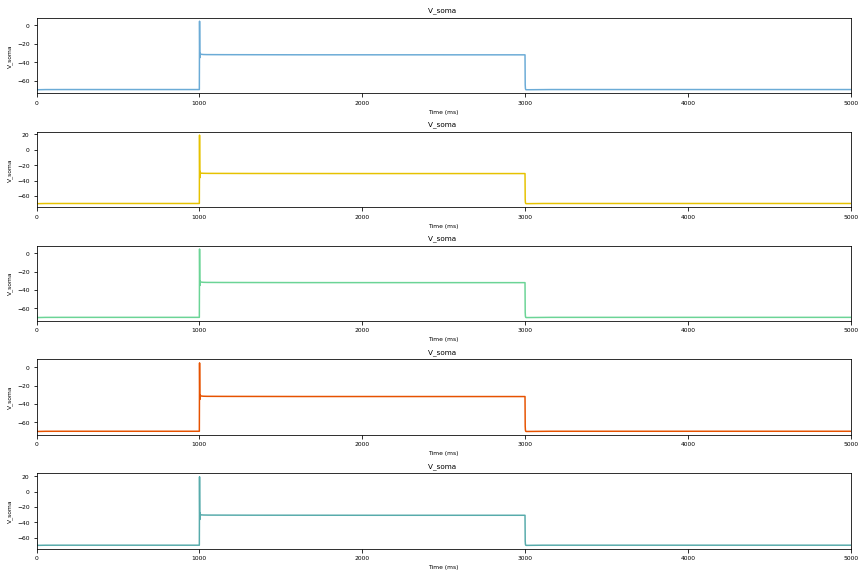

In [4]:
from netpyne import sim
from netpyne import specs
import pickle

cfg = specs.SimConfig()     

cfg.duration = 5000.0 ## Duration of the sim, in ms  
cfg.dt = 0.025
# ~ cfg.seeds = {'conn': 4321, 'stim': 1234, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -65}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.5

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

allpops = ['PY_RS','IN_FS','PY_LTS','PY_IB','PY_IBR']

cfg.recordCells = allpops  # which cells to record from
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = 0.1            

cfg.simLabel = 'Pospischil2008_teste'
cfg.saveFolder = '.'
# cfg.filename =                	## Set file output name
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simConfig', 'netParams', 'simData'] ## 
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = False			##  
cfg.saveCellConns = False		##  

#------------------------------------------------------------------------------
# Analysis and plotting 
#------------------------------------------------------------------------------
cfg.analysis['plotTraces'] = {'include': allpops, 'saveFig': True, 'showFig': False, 'oneFigPer':'trace', 'overlay':False, 'figSize':(12, 8), 'fontSize':6}

#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = 1

delaystim = 1000
durationstim = 2000
step1_current = 20.0
        
cfg.IClamp1 = {'pop': 'PY_RS', 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step1_current}
cfg.IClamp2 = {'pop': 'IN_FS', 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step1_current}
cfg.IClamp3 = {'pop': 'PY_LTS', 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step1_current}
cfg.IClamp4 = {'pop': 'PY_IB', 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step1_current}
cfg.IClamp5 = {'pop': 'PY_IBR', 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': step1_current}


netParams = specs.NetParams()   # object of class NetParams to store the network parameters

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------
for cellName in ['PY_RS', 'IN_FS', 'PY_LTS', 'PY_IB', 'PY_IBR']:
    cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=False,
        conds={'cellType': cellName, 'cellModel': 'HH_full'},
        fileName='cellwrapper_Pospischil2008.py',
        cellName='loadCell',
        cellInstance = True)

# PY_RS
netParams.cellParams['PY_RS_rule']['secs']['soma']['geom']['L'] =  96.0
netParams.cellParams['PY_RS_rule']['secs']['soma']['mechs']['pas']['g'] = 0.001


# IN_FS
netParams.cellParams['IN_FS_rule']['secs']['soma']['geom']['L'] =  96.0
netParams.cellParams['IN_FS_rule']['secs']['soma']['mechs']['hh2']['gnabar'] = 0.007

# PY_IBR
netParams.cellParams['PY_IBR_rule']['secs']['soma']['geom']['L'] =  96.0
netParams.cellParams['PY_IBR_rule']['secs']['soma']['mechs']['hh2']['gnabar'] = 0.007
netParams.cellParams['PY_IBR_rule']['secs']['soma']['mechs']['pas']['g'] = 0.001


#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------

netParams.popParams['PY_RS'] = {'cellType': 'PY_RS', 'cellModel': 'HH_full', 'numCells': 1} 
netParams.popParams['IN_FS'] = {'cellType': 'IN_FS', 'cellModel': 'HH_full', 'numCells': 1} 
netParams.popParams['PY_LTS'] = {'cellType': 'PY_LTS', 'cellModel': 'HH_full', 'numCells': 1} 
netParams.popParams['PY_IB'] = {'cellType': 'PY_IB', 'cellModel': 'HH_full', 'numCells': 1} 
netParams.popParams['PY_IBR'] = {'cellType': 'PY_IBR', 'cellModel': 'HH_full', 'numCells': 1} 

#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
        params = getattr(cfg, key, None)
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}

        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}

sim.createSimulateAnalyze(netParams, cfg)

Plotting recorded cell traces ... trace


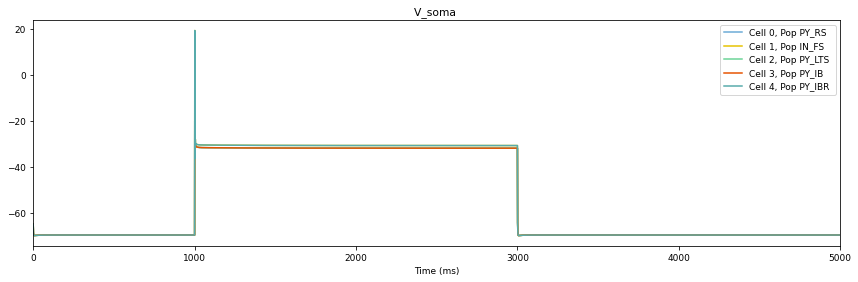

In [5]:
sim.analysis.plotTraces(include=cfg.recordCells, overlay=True, oneFigPer='trace', figSize=(12, 4), fontSize=9, saveFig=True);

In [6]:
netParams.cellParams['PY_RS_rule']['secs']['soma']['geom']

{L: 96.0, nseg: 1, diam: 96.0, Ra: 100.0, cm: 1.0, _repr_mimebundle_: {}}

In [7]:
netParams.cellParams['PY_RS_rule']['secs']['soma']['mechs']['hh2']['gnabar']

0.003

In [8]:
netParams.cellParams['PY_RS_rule']['secs']['soma']['mechs']['pas']['g']

0.001

In [9]:
netParams.cellParams['PY_RS_rule']['secs']['soma']['ions']

{ca: {e: 132.4579341637009, i: 5e-05, o: 2.0}, k: {e: -77.0, i: 54.4, o: 2.5}, na: {e: 50.0, i: 10.0, o: 140.0}, _repr_mimebundle_: {}}

In [10]:
netParams.cellParams['PY_RS_rule']['conds']

{cellType: 'PY_RS', cellModel: 'HH_full', _repr_mimebundle_: {}}